In [1]:
from sklearn.datasets import fetch_mldata
mnist=fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X,y=mnist["data"],mnist["target"]


In [3]:
mnist.data[0].shape

(784,)

In [4]:
y.shape

(70000,)

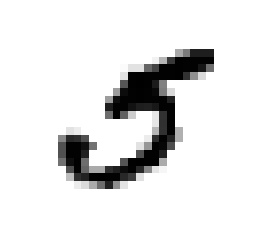

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit=X[36000]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()

In [8]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [9]:
import numpy as np

shuffle_index=np.random.permutation(60000)
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

In [10]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42,max_iter=10)
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=10, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ 5.])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold=StratifiedKFold(n_splits=3,random_state=42)

for train_index, test_index in skfold.split(X_train,y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=(y_train_5[train_index])
    X_test_fold=X_train[test_index]
    y_test_fold=(y_train_5[test_index])
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.9562
0.9497
0.9702


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([ 0.9562,  0.9497,  0.9702])

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([ 0.9115 ,  0.91055,  0.9069 ])

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54203,   376],
       [ 2102,  3319]], dtype=int64)

In [17]:
from sklearn.metrics import precision_score,recall_score
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))

0.898240866035
0.612248662608


In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.72817025010969716

In [19]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([[-127169.28106063, -198840.51166041, -168734.45668506,
         -96287.20653341, -241251.50361429,   83575.19151209,
        -302599.16929267, -218259.10801394, -345503.60855802,
        -235469.56832332]])

In [20]:
threshold=0
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([[False, False, False, False, False,  True, False, False, False,
        False]], dtype=bool)

In [21]:
threshold=-200000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([[ True,  True,  True,  True, False,  True, False, False, False,
        False]], dtype=bool)

In [22]:
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")

In [23]:
y_scores[:,1]

array([-332816.66025899, -354657.81198256, -390957.62819158, ...,
       -353689.98403111,   69367.30538855, -483825.42077782])

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds=precision_recall_curve(y_train_5,y_scores[:,1])

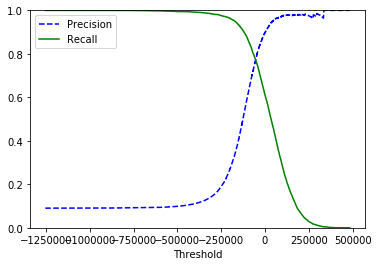

In [25]:
def plot_precision_recall_vs_threshold(precisions,reclaas,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

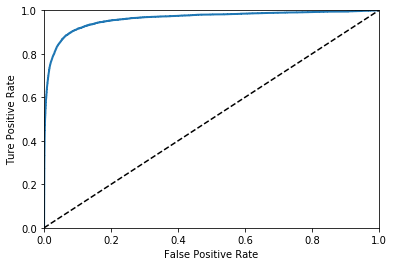

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_train_5, y_scores[:,1])
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('Ture Positive Rate')
plot_roc_curve(fpr,tpr)
plt.show()

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores[:,1])

0.96159674503863324

In [28]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3, method="predict_proba")

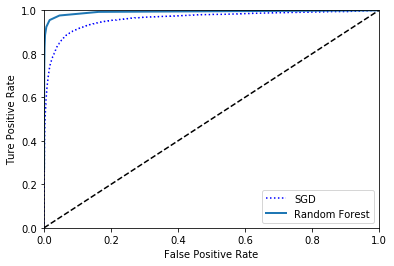

In [29]:
y_scores_forest=y_probas_forest[:,1]
fpr_forest,tpr_forest,threshold_forest=roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr,tpr,'b:',label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

In [30]:
roc_auc_score(y_train_5,y_scores_forest)


0.99272668762317529

In [31]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [32]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_train,cv=3)
f1_score=(y_train,y_train_knn_pred)